# Diagnose fake spectrum normalization

7 Novemeber 2017

In [1]:
import argparse
import warnings
import matplotlib.pyplot as plt
import numpy as np
from spectrum_overload import Spectrum
from models.broadcasted_models import inherent_alpha_model, independent_inherent_alpha_model
from simulators.iam_module import prepare_iam_model_spectra, continuum_alpha
from mingle.utilities.norm import continuum
from mingle.utilities.simulation_utilities import spec_max_delta


/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:

def fake_simulation(wav, params1, params2, gamma, rv, chip=None,
                    limits=[2070, 2180], independent=False, noise=None):
    """Make a fake spectrum with binary params and radial velocities."""
    mod1_spec, mod2_spec = prepare_iam_model_spectra(params1, params2, limits)
    
    mod1_spec.plot()
    mod2_spec.plot()
    plt.show()
    # Estimated flux ratio from models
    if chip is not None:
        inherent_alpha = continuum_alpha(mod1_spec, mod2_spec, chip)
        print("inherent flux ratio = {}, chip={}".format(inherent_alpha, chip))

    # Combine model spectra with iam model
    if independent:
        iam_grid_func = independent_inherent_alpha_model(mod1_spec.xaxis, mod1_spec.flux, mod2_spec.flux,
                                                         rvs=rv, gammas=gamma)
    else:
        iam_grid_func = inherent_alpha_model(mod1_spec.xaxis, mod1_spec.flux, mod2_spec.flux,
                                             rvs=rv, gammas=gamma)
    if wav is None:
        delta = spec_max_delta(mod1_spec, rv, gamma)
        assert np.all(np.isfinite(mod1_spec.xaxis))
        mask = (mod1_spec.xaxis > mod1_spec.xaxis[0] + delta) * (mod1_spec.xaxis < mod1_spec.xaxis[-1] - delta)
        wav = mod1_spec.xaxis[mask]
        print("wav masked", wav)
    
    iam_grid_models = iam_grid_func(wav).squeeze()
    
    print(iam_grid_models)
    assert np.all(np.isfinite(iam_grid_models))
    if noise == "sqrt":
        # Add noise with sigma = 1 / sqrt(N)
        snr = np.sqrt(iam_grid_models)
    elif isinstance(noise, (int, float)):
        snr = noise
    else:
        snr = None

    #Continuum normalize all iam_gird_models
    def axis_continuum(flux):
        """Continuum to apply along axis with predefined variables parameters."""
        return continuum(wav, flux, splits=50, method="exponential", top=5)

    iam_grid_continuum = np.apply_along_axis(axis_continuum, 0, iam_grid_models)

    iam_grid_models = iam_grid_models / iam_grid_continuum
    
    #grid_spectrum = Spectrum(xaxis=wav, flux=iam_grid_models)
    #iam_grid_models = grid_spectrum.normalize("exponential")
    # Add the noise
    from mingle.utilities.simulation_utilities import add_noise
    if snr is not None:
        iam_grid_models = add_noise(iam_grid_models, snr)

    if np.any(np.isnan(iam_grid_models)):
        print("there was some nans")
        pass
    return wav, iam_grid_models


def main(star, sim_num, params1, params2, gamma, rv,
         independent=False, noise=None, suffix=None):
    params1 = [float(par) for par in params1.split(",")]
    params2 = [float(par) for par in params2.split(",")]
    
    
    x_wav, y_wav = fake_simulation(np.linspace(2090, 2150, 2000), params1,
                                   params2, gamma, rv, chip=1, independent=independent, noise=noise)

    
    x, y = fake_simulation(None, params1, params2, gamma, rv, chip=1,
                           independent=independent, noise=noise)
    print(x)
    
    plt.plot(x, y, label="Fake simulation")
    plt.plot(x_wav, y_wav, ".", label="2k")

    plt.xlim([2070, 2170])
    plt.legend()
    plt.title("{0} simnum={1}, noise={2}\n host={3}, companion={4}".format(star, sim_num, noise, params1, params2))
    plt.legend()
    plt.show()

    # NEED to normalize at full wavelenght and then resample

    y_reinterp = np.interp(x_wav, x, y)
   # y_500_reinterp = np.interp(x_wav, x_500, y_500)
   # y_10k_reinterp = np.interp(x_wav, x_10k, y_10k)
  #  y_30k_reinterp = np.interp(x_wav, x_30k, y_30k)

    plt.plot(x_wav, y_wav, ".", label="x_wav")
    plt.plot(x_wav, y_reinterp, ".", label="org sampling.")
  #  plt.plot(x_wav, y_500_reinterp, ".", label="500")
  #  plt.plot(x_wav, y_10k_reinterp, ".", label="10k.")
 #   plt.plot(x_wav, y_30k_reinterp, ".", label="30k.")
    plt.title("Accessing renormaliation")
    plt.legend()
    plt.show()

    plt.plot(y_reinterp - y_wav, label="diff")
    #plt.plot(y_500_reinterp - y_wav, label="500 diff")
    #plt.plot(y_10k_reinterp - y_wav, label="10k diff")
    #plt.plot(y_30k_reinterp - y_wav, label="30k diff")
    plt.legend()
    plt.show()



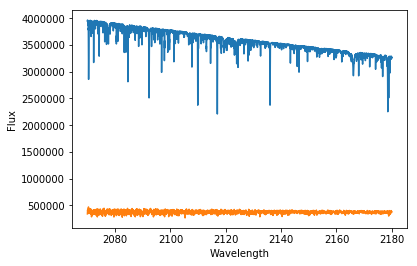

inherent flux ratio = 0.11269309925589412, chip=1
num not finite 7
shape (15017, 1)
locations not finite (array([15010, 15011, 15012, 15013, 15014, 15015, 15016]), array([0, 0, 0, 0, 0, 0, 0]))
num not finite 20
shape (15017, 1, 1)
locations not finite (array([15010, 15011, 15012, 15013, 15014, 15015, 15016]), array([0, 0, 0, 0, 0, 0, 0]))
[ 4198209.75975234  4185559.73916268  4170970.34722462 ...,
  3829458.4978005   3845684.15834915  3826222.79506313]


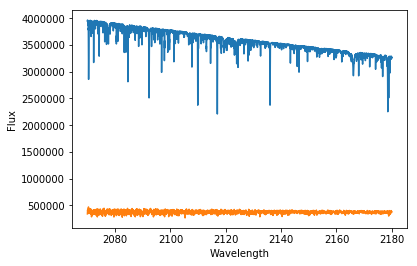

inherent flux ratio = 0.11269309925589412, chip=1
num not finite 7
shape (15017, 1)
locations not finite (array([15010, 15011, 15012, 15013, 15014, 15015, 15016]), array([0, 0, 0, 0, 0, 0, 0]))
num not finite 20
shape (15017, 1, 1)
locations not finite (array([15010, 15011, 15012, 15013, 15014, 15015, 15016]), array([0, 0, 0, 0, 0, 0, 0]))
wav masked [ 2070.39668593  2070.40382429  2070.41096268 ...,  2179.58261965
  2179.59013447  2179.59764931]
[ 4270623.73179726  4257181.64634658  4244912.13999082 ...,
  3604894.16378795  3601624.1898186   3597554.29712326]
[ 2070.39668593  2070.40382429  2070.41096268 ...,  2179.58261965
  2179.59013447  2179.59764931]


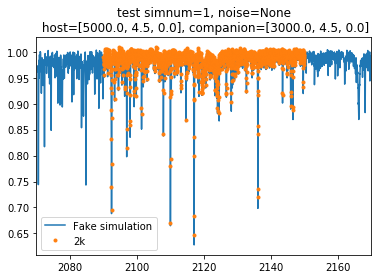

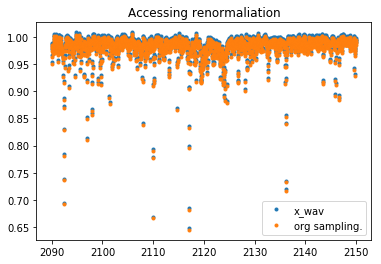

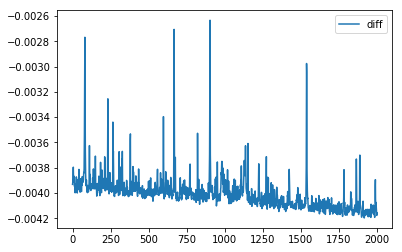

In [3]:
params1 = "5000,4.5, 0.0"
params2 = "3000,4.5, 0.0"
gamma = 20
rv = -7


main("test", "1", params1, params2, gamma, rv,
         independent=False, noise=None, suffix=None)